https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/

In [1]:
import pandas as pd
import numpy as np
df_update = pd.read_csv('/Users/jz/Downloads/job_data/2/df_update.csv', index_col=[0])
skill_cell = pd.read_csv('skill_cell.csv',header=None)

In [2]:
skill_cell.columns=['skill_list']
skill_cell.head()

,skill_list
0,"Python, SQL, R, Spark, Hive, AWS, Data Warehou..."
1,"SQL, R, Excel, Network"
2,"R, Excel"
3,"R, Microsoft Office, Excel, Marketing"
4,R


In [3]:
df_jobskill = pd.concat([df_update['Is_DA'], skill_cell], axis=1)

In [4]:
df_jobskill.head()

,Is_DA,skill_list
0,0.0,"Python, SQL, R, Spark, Hive, AWS, Data Warehou..."
1,1.0,"SQL, R, Excel, Network"
2,0.0,"R, Excel"
3,0.0,"R, Microsoft Office, Excel, Marketing"
4,1.0,R


In [5]:
list_of_skill = skill_cell['skill_list'].to_list()

In [6]:
#data_ready可以直接用list of list skill
#保留desc
#Business Analyst, Business Analyst

In [7]:
import sys
# !{sys.executable} -m spacy download en
import re, numpy as np, pandas as pd
from pprint import pprint

# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt

# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])

%matplotlib inline
warnings.filterwarnings("ignore",category=DeprecationWarning)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)


In [8]:
df = df_jobskill

In [9]:
def sent_to_words(sentences):
    for sent in sentences:
        sent = re.sub('\S*@\S*\s?', '', sent)  # remove emails
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)  

# Convert to list
data = list_of_skill
data_words = list(sent_to_words(data))
print(data_words[:1])
# [['from', 'irwin', 'arnstein', 'subject', 're', 'recommendation', 'on', 'duc', 'summary', 'whats', 'it', 'worth', 'distribution', 'usa', 'expires', 'sat', 'may', 'gmt', ...trucated...]]

[['python', 'sql', 'spark', 'hive', 'aws', 'data', 'warehouse', 'business', 'intelligence', 'network']]


In [10]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# !python3 -m spacy download en  # run in terminal once
def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load('en', disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

data_ready = process_words(data_words)  # processed Text Data!

In [11]:
# Create Dictionary
id2word = corpora.Dictionary(data_ready)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=4, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

pprint(lda_model.print_topics())


[(0,
  '0.309*"marketing" + 0.088*"analytic" + 0.059*"saa" + 0.052*"omniture" + '
  '0.052*"seo" + 0.035*"digital" + 0.034*"market" + 0.033*"visual" + '
  '0.030*"workday" + 0.030*"sdlc"'),
 (1,
  '0.351*"office" + 0.316*"excel" + 0.040*"account" + 0.026*"program" + '
  '0.025*"id" + 0.021*"window" + 0.018*"chef" + 0.018*"svn" + '
  '0.018*"kubernete" + 0.009*"clinical"'),
 (2,
  '0.224*"business" + 0.167*"intelligence" + 0.122*"datum" + 0.105*"analysis" '
  '+ 0.031*"science" + 0.030*"network" + 0.025*"ai" + 0.024*"warehouse" + '
  '0.024*"big" + 0.023*"project"'),
 (3,
  '0.331*"management" + 0.117*"power" + 0.110*"accounting" + '
  '0.046*"sharepoint" + 0.038*"peoplesoft" + 0.021*"platform" + '
  '0.021*"regulatory" + 0.021*"reporting" + 0.020*"process" + '
  '0.018*"software"')]


In [12]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,2.0,0.875,"business, intelligence, datum, analysis, scien...","[datum, warehouse, business, intelligence, net..."
1,1,0.0,0.250,"marketing, analytic, saa, omniture, seo, digit...",[]
2,2,0.0,0.250,"marketing, analytic, saa, omniture, seo, digit...",[]
3,3,1.0,0.625,"office, excel, account, program, id, window, c...",[office]
4,4,0.0,0.250,"marketing, analytic, saa, omniture, seo, digit...",[]
5,5,0.0,0.250,"marketing, analytic, saa, omniture, seo, digit...",[]
6,6,0.0,0.250,"marketing, analytic, saa, omniture, seo, digit...",[]
7,7,0.0,0.250,"marketing, analytic, saa, omniture, seo, digit...",[]
8,8,1.0,0.750,"office, excel, account, program, id, window, c...","[office, excel]"
9,9,0.0,0.250,"marketing, analytic, saa, omniture, seo, digit...",[]


In [13]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.8750,"marketing, analytic, saa, omniture, seo, digital, market, visual, workday, sdlc","[market, analytic, digital, marketing, omniture]"
1,1.0,0.8498,"office, excel, account, program, id, window, chef, svn, kubernete, clinical","[service, certify, internal, auditor]"
2,2.0,0.8928,"business, intelligence, datum, analysis, science, network, ai, warehouse, big, project","[machine, learn, big, datum, ai, analysis]"
3,3.0,0.8750,"management, power, accounting, sharepoint, peoplesoft, platform, regulatory, reporting, process,...","[audits, manage, care, regulatory, reporting]"


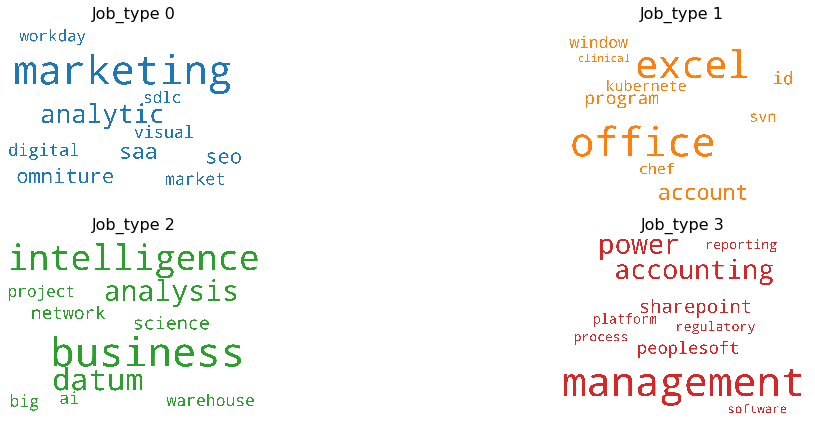

In [14]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=100,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(20,6), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=400)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Job_type ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

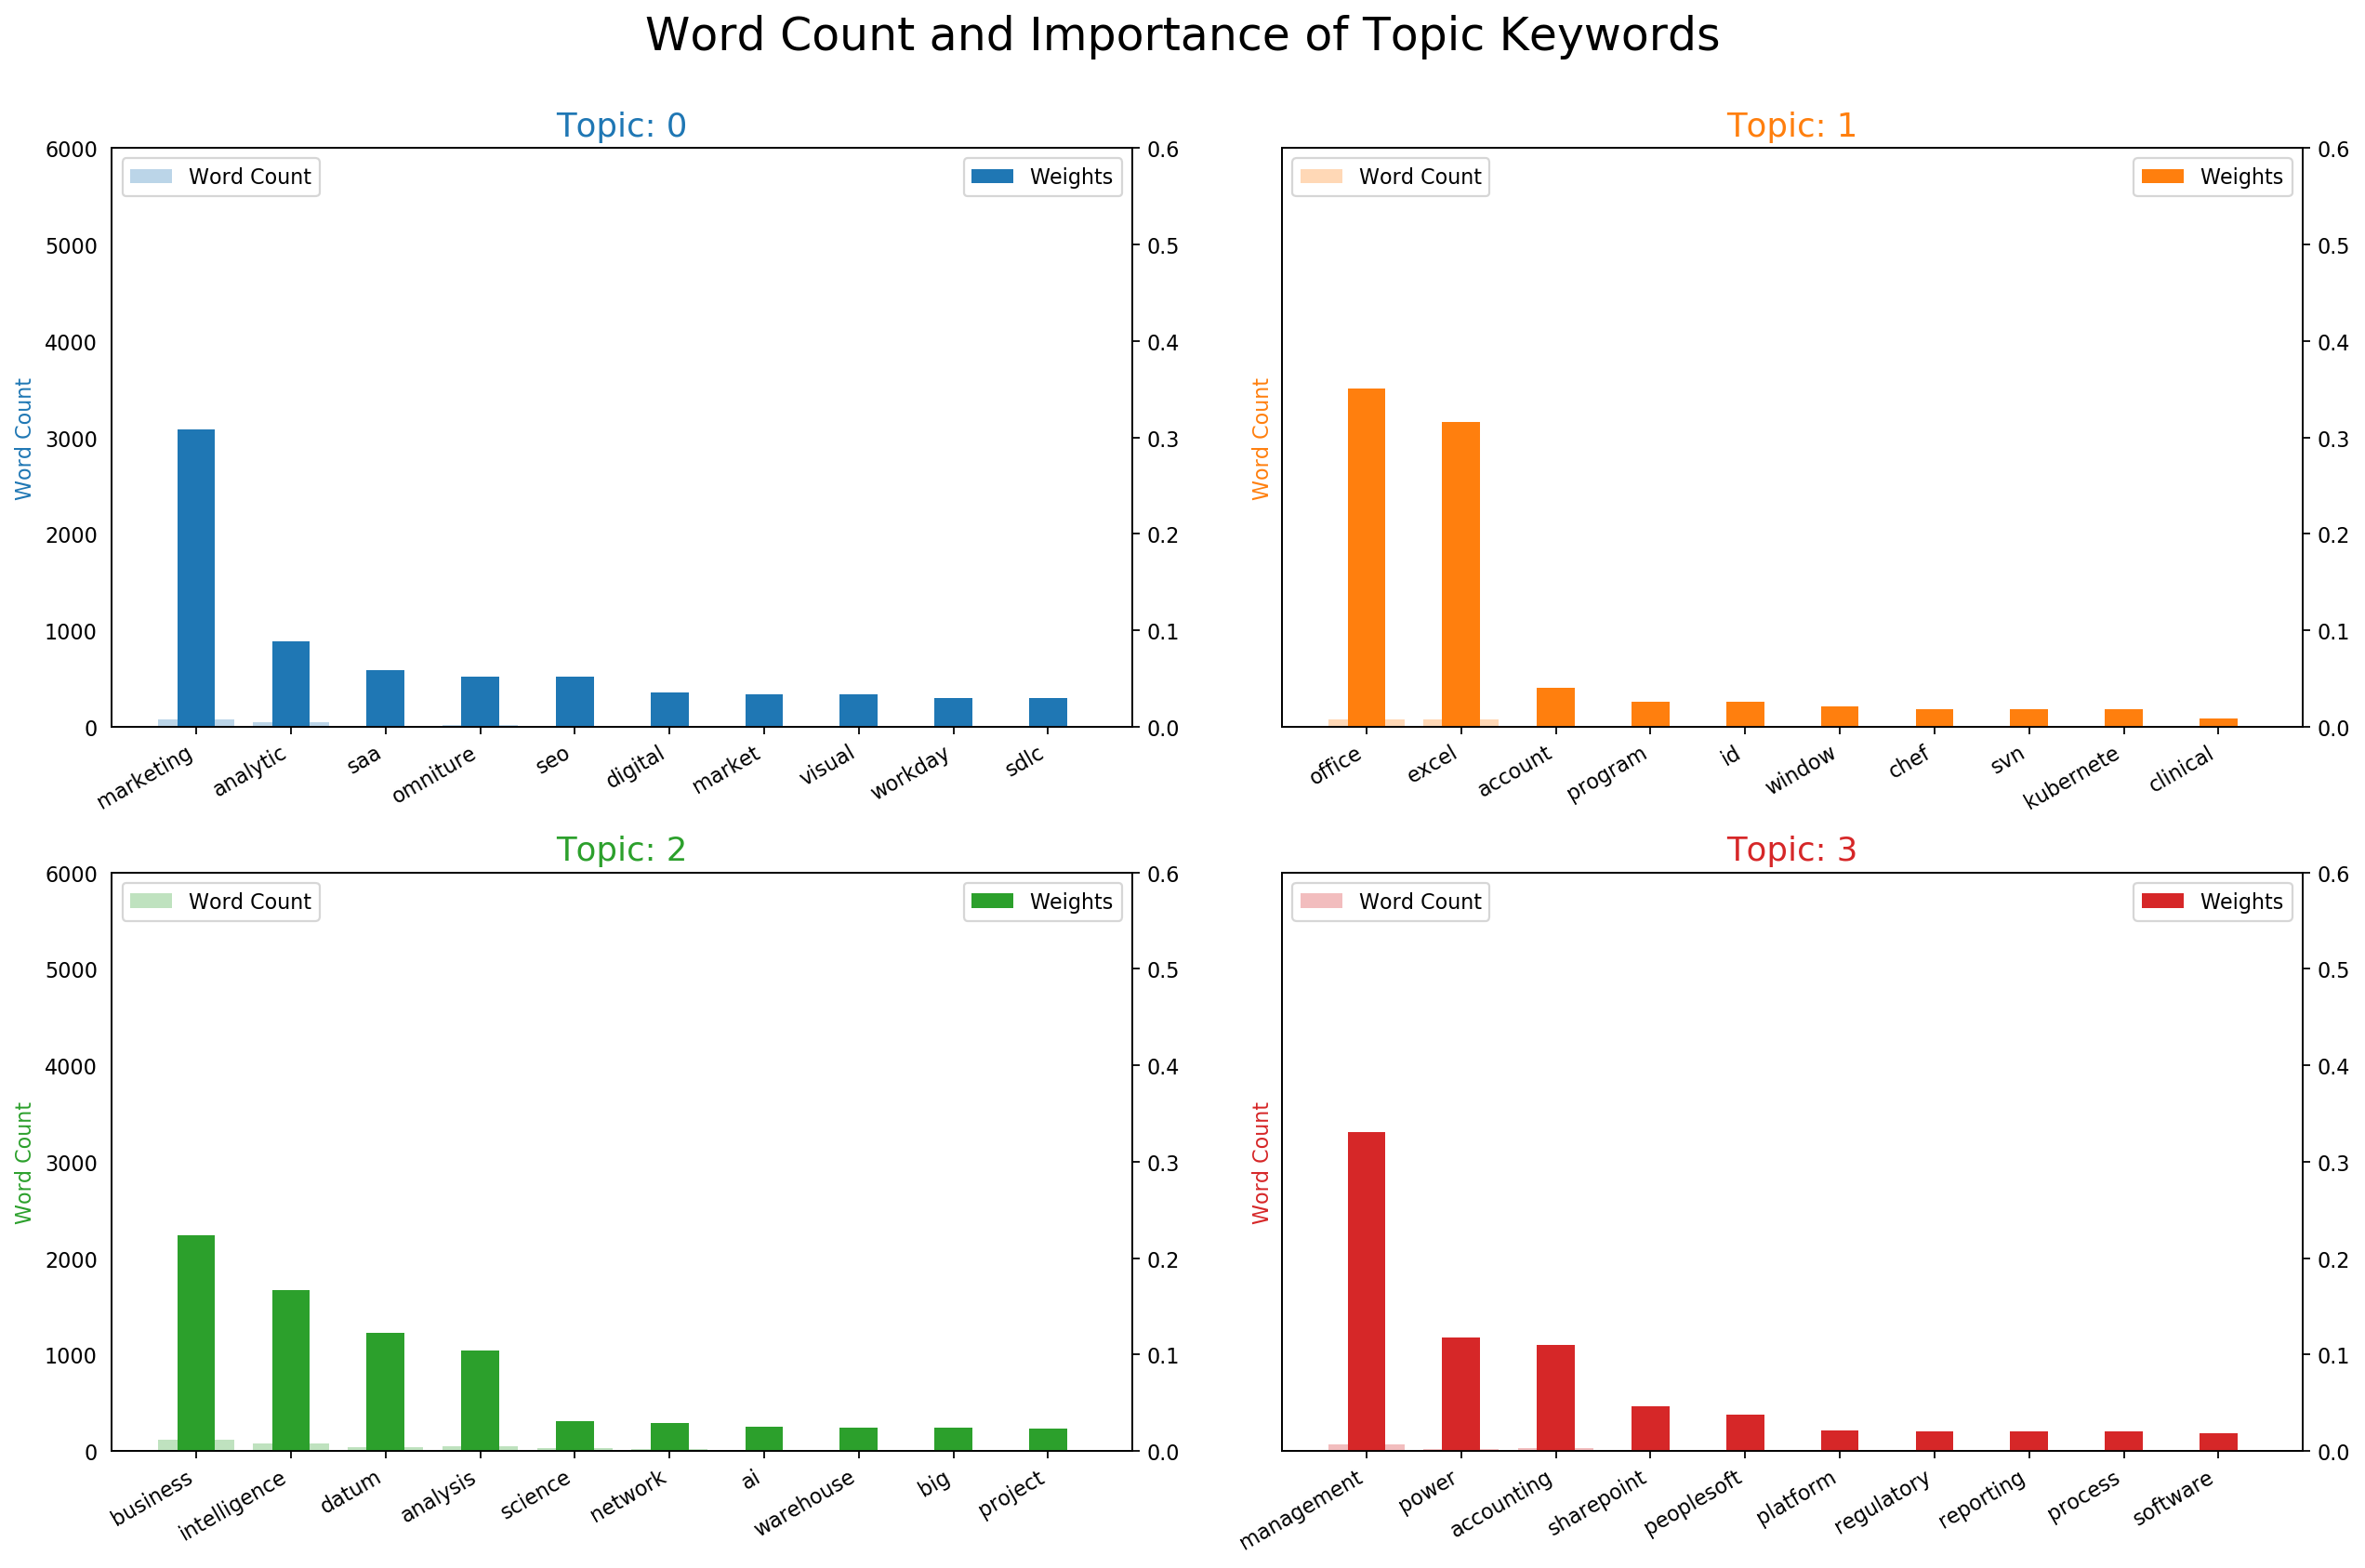

In [15]:
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in data_ready for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 2, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.8, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.4, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.6); ax.set_ylim(0, 6000)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

In [17]:
# Sentence Coloring of N Sentences
def topics_per_document(model, corpus, start=0, end=1):
    corpus_sel = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs, wordid_topics, wordid_phivalues = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return(dominant_topics, topic_percentages)

dominant_topics, topic_percentages = topics_per_document(model=lda_model, corpus=corpus, end=-1)            

# Distribution of Dominant Topics in Each Document
df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()

# Top 3 Keywords for each Topic
topic_top3words = [(i, topic) for i, topics in lda_model.show_topics(formatted=False) 
                                 for j, (topic, wt) in enumerate(topics) if j < 3]

df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg(', \n'.join)
df_top3words.reset_index(level=0,inplace=True)

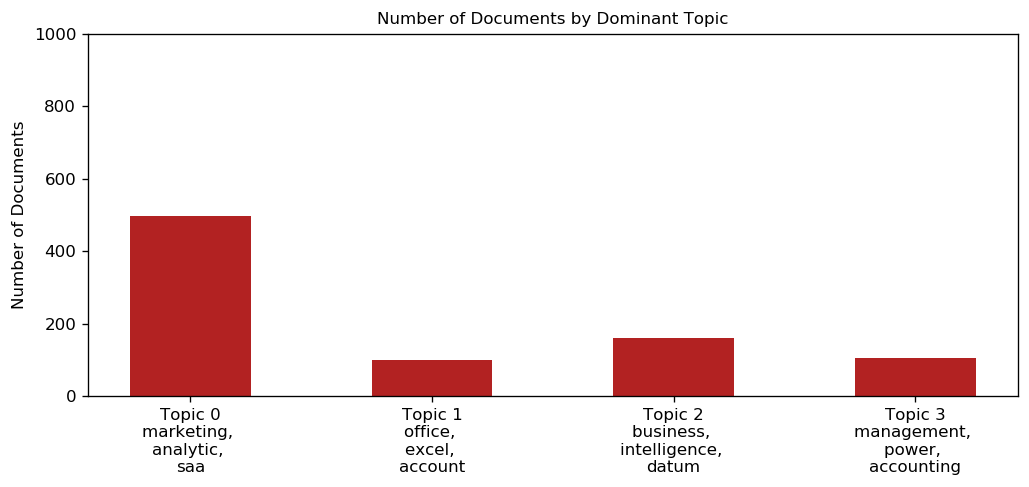

In [18]:
from matplotlib.ticker import FuncFormatter

# Plot
fig, (ax1) = plt.subplots(1, 1, figsize=(10, 4), dpi=120, sharey=True)

# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x)+ '\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0])
ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=10))
ax1.set_ylabel('Number of Documents')
ax1.set_ylim(0, 1000)

plt.show()

In [19]:
# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 4
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 457 samples in 0.000s...
[t-SNE] Computed neighbors for 457 samples in 0.007s...
[t-SNE] Computed conditional probabilities for sample 457 / 457
[t-SNE] Mean sigma: 0.000001
[t-SNE] KL divergence after 250 iterations with early exaggeration: 50.580872
[t-SNE] KL divergence after 1000 iterations: -0.095471


Loading BokehJS ...

In [20]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

/Users/jz/.local/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.358471  0.048715       1        1  35.643517
3     -0.092883 -0.280098       2        1  23.938040
0     -0.092324 -0.041870       3        1  21.574177
1     -0.173264  0.273253       4        1  18.844263, topic_info=    Category       Freq          Term      Total  loglift  logprob
16   Default  92.000000    management  92.000000  30.0000  30.0000
5    Default  77.000000        office  77.000000  29.0000  29.0000
8    Default  78.000000     marketing  78.000000  28.0000  28.0000
6    Default  69.000000         excel  69.000000  27.0000  27.0000
0    Default  93.000000      business  93.000000  26.0000  26.0000
2    Default  69.000000  intelligence  69.000000  25.0000  25.0000
1    Default  51.000000         datum  51.000000  24.0000  24.0000
45   Default  33.000000         power  33.000000  23.0000  23.0000
15   Default  31.000000    accounting  31.000000  22.0000  22.0000
36   Default  44.000000      analysis  44.000000  21.0000  21.0000
11   Default  22.000000      analytic  22.000000  20.0000  20.0000
22   Default  15.000000           saa  15.000000  19.0000  19.0000
12   Default  13.000000      omniture  13.000000  18.0000  18.0000
40   Default  13.000000           seo  13.000000  17.0000  17.0000
9    Default  13.000000    sharepoint  13.000000  16.0000  16.0000
46   Default   9.000000       account   9.000000  15.0000  15.0000
41   Default  11.000000    peoplesoft  11.000000  14.0000  14.0000
32   Default   9.000000       digital   9.000000  13.0000  13.0000
18   Default   8.000000        market   8.000000  12.0000  12.0000
81   Default   8.000000        visual   8.000000  11.0000  11.0000
14   Default   8.000000          sdlc   8.000000  10.0000  10.0000
30   Default  13.000000       science  13.000000   9.0000   9.0000
13   Default   8.000000       workday   8.000000   8.0000   8.0000
3    Default  12.000000       network  12.000000   7.0000   7.0000
132  Default   7.000000   performance   7.000000   6.0000   6.0000
19   Default   6.000000     operation   6.000000   5.0000   5.0000
48   Default   6.000000            id   6.000000   4.0000   4.0000
110  Default   7.000000       program   7.000000   3.0000   3.0000
50   Default  10.000000            ai  10.000000   2.0000   2.0000
4    Default  10.000000     warehouse  10.000000   1.0000   1.0000
..       ...        ...           ...        ...      ...      ...
130   Topic4   4.039119     kubernete   4.673801   1.5230  -3.9946
129   Topic4   4.039119          chef   4.673801   1.5230  -3.9946
110   Topic4   5.633760       program   7.028871   1.4477  -3.6619
49    Topic4   1.873245         trial   2.451551   1.3999  -4.7630
47    Topic4   1.873245      clinical   2.451551   1.3999  -4.7630
59    Topic4   1.254983       service   1.833025   1.2901  -5.1635
123   Topic4   1.331070   development   1.967608   1.2781  -5.1047
67    Topic4   0.989826        access   1.570585   1.2073  -5.4009
28    Topic4   0.973626       android   1.573830   1.1887  -5.4174
119   Topic4   0.924954          lean   1.548389   1.1537  -5.4687
58    Topic4   0.829030      customer   1.407072   1.1400  -5.5782
111   Topic4   0.692880       auditor   1.274915   1.0592  -5.7576
112   Topic4   0.692880       certify   1.274915   1.0592  -5.7576
113   Topic4   0.692880      internal   1.274915   1.0592  -5.7576
104   Topic4   0.342818          itil   0.923527   0.6780  -6.4612
103   Topic4   0.337905        sybase   0.923676   0.6634  -6.4756
98    Topic4   0.295942       ansible   0.880843   0.5782  -6.6082
94    Topic4   0.236579  segmentation   0.843644   0.3975  -6.8321
105   Topic4   0.237250        cerner   0.929698   0.3032  -6.8293
97    Topic4   0.221936   doubleclick   0.874472   0.2977  -6.8960
44    Topic4   0.190326       medical   0.769981   0.2713  -7.0497
43    Topic4   0.190326     insurance   0.769981   0.2713  -7.0497
38    Topic4   